In [1]:
import numpy as np

import pandas as pd

import xarray as xr

from affine import Affine

import matplotlib.pyplot as plt

import rasterio 

from rasterio.plot import show

from glob import glob

import rioxarray

In [2]:
from scipy import stats
import dask.array as da
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from statsmodels.graphics.gofplots import qqplot_2samples


In [3]:
# start a Dask client
from dask.distributed import Client

client = Client()
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.72 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55941,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.72 GiB
Comm: tcp://127.0.0.1:55978,Total threads: 3
Dashboard: http://127.0.0.1:55979/status,Memory: 7.93 GiB
Nanny: tcp://127.0.0.1:55947,


In [4]:

da1 = rasterio.open(r"C:\Users\qijue.chen\Downloads\2D_model_output_sample_data\2D_model_output_sample_data\terrain\Terrain_Addison_M03.tif",masked=True)
#transform = Affine.from_gdal(*da.attrs['transform']) # this is important to retain the geographic attributes from the file
da1

<open DatasetReader name='C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/terrain/Terrain_Addison_M03.tif' mode='r'>

In [5]:
da1.read_masks(1)

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

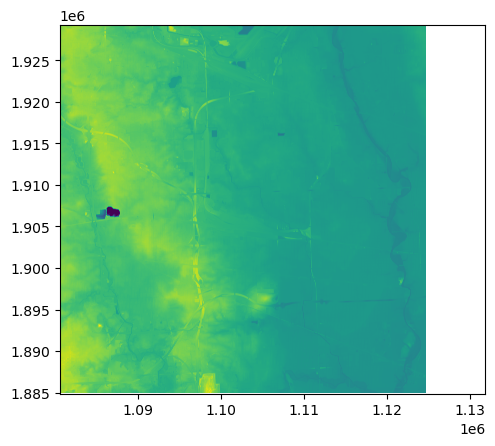

<Axes: >

In [6]:
show(da1)

In [7]:
da1 = xr.open_rasterio(r"C:\Users\qijue.chen\Downloads\2D_model_output_sample_data\2D_model_output_sample_data\wsel_grids\WSE_Addison_M03_H04_E4001.tif")
transform = Affine.from_gdal(*da1.attrs['transform']) # this is important to retain the geographic attributes from the file
print(da1)

<xarray.DataArray (band: 1, y: 8899, x: 10249)>
[91205851 values with dtype=float32]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 1.929e+06 1.929e+06 1.929e+06 ... 1.885e+06 1.885e+06
  * x        (x) float64 1.081e+06 1.081e+06 1.081e+06 ... 1.132e+06 1.132e+06
Attributes:
    transform:                 (5.0, 0.0, 1080548.6459105245, 0.0, -5.0, 1929...
    crs:                       +init=epsg:3435
    res:                       (5.0, 5.0)
    is_tiled:                  1
    nodatavals:                (-9999.0,)
    scales:                    (1.0,)
    offsets:                   (0.0,)
    AREA_OR_POINT:             Area
    HISTOGRAM:                 706|65|79|98|144|70|55|300|37|40|42|42|69|84|8...
    TIFFTAG_ARTIST:            HEC-RAS
    TIFFTAG_IMAGEDESCRIPTION:  WSE (Max)


C:\Users\qijue.chen\AppData\Local\Temp\ipykernel_11400\936586548.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  da1 = xr.open_rasterio(r"C:\Users\qijue.chen\Downloads\2D_model_output_sample_data\2D_model_output_sample_data\wsel_grids\WSE_Addison_M03_H04_E4001.tif")


In [8]:
da1_ = np.ma.masked_array(da1, da1 == -9999.0)

In [9]:
# ds = xr.DataArray.to_dataset(da1, name = "wse dataset")
# ds['band']
band = xr.DataArray.to_numpy(da1)
print(band)

[[[-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  ...
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]]]


In [10]:
print(da1['band'])

<xarray.DataArray 'band' (band: 1)>
array([1])
Coordinates:
  * band     (band) int32 1


In [11]:
#res = xr.apply_ufunc(weibull_fit, da1, input_core_dims=[["band"]], kwargs={'exceed_p': exceedance_p}, dask = 'allowed', vectorize = True)

In [12]:
print(type(da1))
print("the minimum raster value is: ", np.nanmin(da1.values))
print("the maximum raster value is: ", np.nanmax(da1.values))

<class 'xarray.core.dataarray.DataArray'>
the minimum raster value is:  -9999.0
the maximum raster value is:  673.82513


In [15]:
# Path of the folder containing the terrain .tiff files
IMG_PATH = 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/terrain/Terrain_Addison_M03.tif'

terrain = rioxarray.open_rasterio(IMG_PATH, chunks = (1,128,128), masked = True)

#slice xds - may need to compute 
terrain = terrain[:,300:500,200:600]

# Stack bands into a single DataArray
terrain

<xarray.DataArray (band: 1, y: 200, x: 400)>
dask.array<getitem, shape=(1, 200, 400), dtype=float32, chunksize=(1, 116, 128), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.082e+06 1.082e+06 ... 1.084e+06 1.084e+06
  * y            (y) float64 1.928e+06 1.928e+06 ... 1.927e+06 1.927e+06
    spatial_ref  int32 0
Attributes: (12/19)
    AREA_OR_POINT:             Area
    HISTOGRAM:                 42941|1342|609|551|466|413|411|518|461|500|424...
    TIFFTAG_ARTIST:            HEC-RAS
    TIFFTAG_IMAGEDESCRIPTION:  Terrain Raster
    TIFFTAG_SOFTWARE:          HEC-RAS
    DECIMAL_PRECISION:         ThirtySeconds
    ...                        ...
    STATISTICS_SKIPFACTORY:    1
    STATISTICS_STDDEV:         26.292600539339
    TYPE:                      Elevation
    UNITS:                     Feet
    scale_factor:              1.0
    add_offset:                0.0

In [16]:
# Path of the folder containing the .tiff files
IMG_PATH = 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/wsel_grids/'

# List of .tiff files
wse_layers = glob(f"{IMG_PATH}*.tif")
wse_layers.sort() # sorted list
        
ls_wse_layers = [] # list filled with the first layer of each file
for l in wse_layers:
    xds = rioxarray.open_rasterio(l, chunks = (1,128,128), masked = True)
    #slice xds - may need to compute 
    xds = xds[:,300:500,200:600]
    ls_wse_layers.append(xds)
    wtr_depth = da.subtract(xds,terrain)
    ls_wse_layers.append(wtr_depth) # index 0 corresponds to the first band of each file

# Stack bands into a single DataArray
print(type(ls_wse_layers[0]))

# change the lib to rioxarray-rasterio
# chunk parameter 128*128
# ***check xds shape 


<class 'xarray.core.dataarray.DataArray'>


In [17]:
print(ls_wse_layers[0])

<xarray.DataArray (band: 1, y: 200, x: 400)>
dask.array<getitem, shape=(1, 200, 400), dtype=float32, chunksize=(1, 116, 128), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.082e+06 1.082e+06 ... 1.084e+06 1.084e+06
  * y            (y) float64 1.928e+06 1.928e+06 ... 1.927e+06 1.927e+06
    spatial_ref  int32 0
Attributes: (12/14)
    AREA_OR_POINT:             Area
    HISTOGRAM:                 706|65|79|98|144|70|55|300|37|40|42|42|69|84|8...
    TIFFTAG_ARTIST:            HEC-RAS
    TIFFTAG_IMAGEDESCRIPTION:  WSE (Max)
    DECIMAL_PRECISION:         None
    FRACTION_NODATA:           0.9851135
    ...                        ...
    STATISTICS_MINIMUM:        611.343505859375
    STATISTICS_STDDEV:         13.1107780925866
    TYPE:                      Water Surface Elevation
    UNITS:                     feet
    scale_factor:              1.0
    add_offset:                0.0


In [18]:
ds = ls_wse_layers[0].to_dataset(name = "wse1")

idx = 1
for i in range(idx,len(ls_wse_layers)):
    var_name = "wse"+ str(i+1)
    ds[var_name] = ls_wse_layers[i]
    
ds


<xarray.Dataset>
Dimensions:      (band: 1, x: 400, y: 200)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.082e+06 1.082e+06 ... 1.084e+06 1.084e+06
  * y            (y) float64 1.928e+06 1.928e+06 ... 1.927e+06 1.927e+06
    spatial_ref  int32 0
Data variables: (12/192)
    wse1         (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>
    wse2         (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>
    wse3         (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>
    wse4         (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>
    wse5         (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>
    wse6         (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>
    ...           ...
    wse187       (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>
    wse188       (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>
    wse189       (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>
    wse190       (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>
    wse191       (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>
    wse192       (band, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>

In [19]:
# ds = ds.sel('band')
# ds = ds.drop_vars('spatial_ref')
# ds

In [20]:

index_list = range(1, 97)

ds = xr.concat(
    [ds[f"wse{i}"] for i in range(1, len(index_list) + 1)],
    dim=pd.Index(index_list, name="scenario"),
).to_dataset(name="all_runs")




In [21]:
ds['all_runs']

,Array,Chunk
Bytes,29.30 MiB,58.00 kiB
Shape,"(96, 1, 200, 400)","(1, 1, 116, 128)"
Count,280191 Tasks,768 Chunks
Type,float32,numpy.ndarray


In [22]:
#ds = ds.drop_vars('scenario')
#ds_test = ds.sel(scenario = 1)
ds_test = ds.sel(band = 1)

In [23]:
ds_test

<xarray.Dataset>
Dimensions:      (x: 400, y: 200, scenario: 96)
Coordinates:
    band         int32 1
  * x            (x) float64 1.082e+06 1.082e+06 ... 1.084e+06 1.084e+06
  * y            (y) float64 1.928e+06 1.928e+06 ... 1.927e+06 1.927e+06
    spatial_ref  int32 0
  * scenario     (scenario) int64 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
Data variables:
    all_runs     (scenario, y, x) float32 dask.array<chunksize=(1, 84, 56), meta=np.ndarray>

In [24]:
da_test = ds_test.to_array() 

In [25]:
da_test

,Array,Chunk
Bytes,29.30 MiB,58.00 kiB
Shape,"(1, 96, 200, 400)","(1, 1, 116, 128)"
Count,281727 Tasks,768 Chunks
Type,float32,numpy.ndarray


In [26]:
da_test = da_test.sel(variable = 'all_runs')
da_test

<xarray.DataArray (scenario: 96, y: 200, x: 400)>
dask.array<getitem, shape=(96, 200, 400), dtype=float32, chunksize=(1, 116, 128), chunktype=numpy.ndarray>
Coordinates:
    band         int32 1
  * x            (x) float64 1.082e+06 1.082e+06 ... 1.084e+06 1.084e+06
  * y            (y) float64 1.928e+06 1.928e+06 ... 1.927e+06 1.927e+06
    spatial_ref  int32 0
  * scenario     (scenario) int64 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
    variable     <U8 'all_runs'

# GEV Distribution

In [27]:
da_test = da.nan_to_num(da_test,nan = 0.0)
da_test

array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.000

In [29]:
np.min(da_test)

0.0

In [30]:
from scipy.stats import genextreme as gev

In [31]:
# fit an GEV distrubtion to every stream's annual maximum flows.

def fit_gev(data: np.ndarray):
    # Fit an GEV distribtion to a 1-dimensional NumPy array.
    # Returns fit parameters: (shape, loc, scale)
    # If any of the 1D array values are NaN, returns (None, None, None)
    if np.isnan(data).any():
        return (np.nan, np.nan, np.nan, np.nan) 
    shape, loc, scale = gev.fit(data)
    cdf = gev.cdf(data,shape,scale,loc)
    return [shape, loc, scale]

da_fit = da.apply_along_axis(fit_gev, 0, da_test)
da_fit

C:\Users\qijue.chen\AppData\Local\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:407: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


dask.array<fit_gev-along-axis, shape=(3, 200, 400), dtype=float64, chunksize=(3, 200, 400), chunktype=numpy.ndarray>

In [32]:
exceedance_p = np.array([0.9, 0.99])

def gev_quantiles(params, probs):
    # return quantile values for a given set of annual exceedance probabilities
    shape = params[0]
    loc = params[1]
    scale = params[2]
    if all(params):
        return gev.ppf(probs, shape, loc=loc, scale=scale)
    bad_result = np.empty((len(probs),))
    bad_result[:] = np.nan
    return bad_result

da_quantiles = da.apply_along_axis(gev_quantiles, 0, da_fit, exceedance_p, shape=(len(exceedance_p),), dtype=float)
da_quantiles

dask.array<gev_quantiles-along-axis, shape=(2, 200, 400), dtype=float64, chunksize=(2, 200, 400), chunktype=numpy.ndarray>

# LP3 Distribution

In [33]:
# fit an LP-III distrubtion to every stream's annual maximum flows.

def fit_pearson3_log(data: np.ndarray):
    # Fit a log LP-III distribtion to a 1-dimensional NumPy array.
    # Returns fit parameters: (skew, loc, scale)
    # If any of the 1D array values are NaN, returns (None, None, None)
    # data[data == 0] = np.nan
    # if np.isnan(data).any():
    #     return (np.nan, np.nan, np.nan,np.nan)
    skew, loc, scale = stats.pearson3.fit(np.log(data))
    return [skew, loc, scale]

da_fit = da.apply_along_axis(fit_pearson3_log, 0, da_test)
da_fit

dask.array<fit_pearson3_log-along-axis, shape=(3, 200, 400), dtype=float64, chunksize=(3, 200, 400), chunktype=numpy.ndarray>

In [34]:
def pearson3_log_quantiles(params, probs):
    # return quantile values for a given set of annual exceedance probabilities
    skew = params[0]
    loc = params[1]
    scale = params[2]
    if all(params):
        return np.exp(stats.pearson3.ppf(probs, skew, loc=loc, scale=scale))
    bad_result = np.empty((len(probs),))
    bad_result[:] = np.nan
    return bad_result

da_quantiles = da.apply_along_axis(pearson3_log_quantiles, 0, da_fit, exceedance_p, shape=(len(exceedance_p),), dtype=float)
da_quantiles

dask.array<pearson3_log_quantiles-along-axis, shape=(2, 200, 400), dtype=float64, chunksize=(2, 200, 400), chunktype=numpy.ndarray>

# Pearson3 Distribution

In [35]:
# fit an LP-III distrubtion to every stream's annual maximum flows.

def fit_pearson3(data: np.ndarray):
    # Fit an LP-III distribtion to a 1-dimensional NumPy array.
    # Returns fit parameters: (skew, loc, scale)
    # If any of the 1D array values are NaN, returns (None, None, None)
    skew, loc, scale = stats.pearson3.fit(data)
    cdf = stats.pearson3.cdf(data,skew,loc,scale)
    return [skew, loc, scale]

da_fit = da.apply_along_axis(fit_pearson3, 0, da_test)
da_fit

dask.array<fit_pearson3-along-axis, shape=(3, 200, 400), dtype=float64, chunksize=(3, 200, 400), chunktype=numpy.ndarray>

In [36]:
def pearson3_quantiles(params, probs):
    # return quantile values for a given set of annual exceedance probabilities
    skew = params[0]
    loc = params[1]
    scale = params[2]
   
    if all(params):
        return stats.pearson3.ppf(probs, skew, loc=loc, scale=scale)
    bad_result = np.empty((len(probs),))
    bad_result[:] = np.nan
    return bad_result

da_quantiles = da.apply_along_axis(pearson3_quantiles, 0, da_fit, exceedance_p, shape=(len(exceedance_p),), dtype=float)
da_quantiles

dask.array<pearson3_quantiles-along-axis, shape=(2, 200, 400), dtype=float64, chunksize=(2, 200, 400), chunktype=numpy.ndarray>

# Gumbel Distribution

In [37]:
def fit_gumbel(data: np.ndarray):
    # Fit an GEV distribtion to a 1-dimensional NumPy array.
    # Returns fit parameters: (shape, loc, scale)
    # If any of the 1D array values are NaN, returns (None, None, None)
    loc, scale = stats.gumbel_r.fit(data)
    return [loc, scale]

da_fit = da.apply_along_axis(fit_gumbel, 0,  da_test)
da_fit

TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

# Weibull Distribution

In [38]:
da_test = ds_test.to_array() 
da_test = da_test.sel(variable = 'all_runs')
da_test = np.nan_to_num(da_test,nan = 1)
da_test

array([[[1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        ...,
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],

       [[1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ...,
         1.000

In [40]:
np.min(da_test)

0.0010375977

In [41]:
exceedance_p = np.array([0.9, 0.99])

def weibull_fit(data: np.ndarray, exceed_p):
    # if np.isnan(data).any():
    #     return (np.nan, np.nan)
    ranks = data.argsort().argsort()+1
    probs = ranks/(len(ranks)+1)
    slope, intercept = np.polyfit(probs, np.log10(data), 1)
    #levels = 10**(slope*exceed_p+intercept)
    return slope, intercept

da_fit = da.apply_along_axis(weibull_fit, 0,  da_test, exceedance_p)
da_fit


C:\Users\qijue.chen\AppData\Local\anaconda3\lib\site-packages\dask\array\routines.py:508: RankWarning: Polyfit may be poorly conditioned
  test_result = np.array(func1d(test_data, *args, **kwargs))


dask.array<weibull_fit-along-axis, shape=(2, 200, 400), dtype=float64, chunksize=(2, 200, 400), chunktype=numpy.ndarray>

Weibull Distribution

In [42]:
ds

,Array,Chunk
Bytes,29.30 MiB,58.00 kiB
Shape,"(96, 1, 200, 400)","(1, 1, 116, 128)"
Count,280191 Tasks,768 Chunks
Type,float32,numpy.ndarray


In [43]:
def weibull_quantiles(params, exceed_p):
    slope = params[0]
    intercept = params[1]
    if any(params):
        return 10**(slope*exceed_p+intercept)
    bad_result = np.empty((len(exceed_p),))
    bad_result[:] = np.nan
    return bad_result
    
da_quantiles = da.apply_along_axis(weibull_quantiles, 0, da_fit, exceedance_p, shape=(len(exceedance_p),), dtype=float)
da_quantiles

dask.array<weibull_quantiles-along-axis, shape=(2, 200, 400), dtype=float64, chunksize=(2, 200, 400), chunktype=numpy.ndarray>

In [44]:
da_meta = da.concatenate([da_fit, da_quantiles], axis=0)
da_meta

dask.array<concatenate, shape=(4, 200, 400), dtype=float64, chunksize=(2, 200, 400), chunktype=numpy.ndarray>

In [45]:
# da_meta = np.nan_to_num(da_meta)

In [46]:
da_meta.compute()

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  1.07817670e+00,  4.57594507e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  4.76300950e+00,  4.36007307e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  3.09164272e+00,  4.33033277e+00],
        ...,
        [ 4.66209300e+00,  4.63607952e+00,  4.66193090e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.30621143e+00,  4.38229589e+00,  4.38169886e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -4.87258509e-01, -1.43291822e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -2.03455590e

In [47]:
da_meta_rechunked = da_meta.rechunk((1, 200, 400))

In [48]:
import skimage.io

def save_file(arr, block_info=None):
    """ Save file to foo-x-y.tif, where x and y are block locations """
    filename = "foo-" + "-".join(map(str, block_info[0]["chunk-location"])) + ".tif"
    skimage.io.imsave(filename, arr)
    return arr

da_meta_rechunked.map_blocks(save_file, dtype=da_meta.dtype).compute()       # call function on every block

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  1.07817670e+00,  4.57594507e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  4.76300950e+00,  4.36007307e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  3.09164272e+00,  4.33033277e+00],
        ...,
        [ 4.66209300e+00,  4.63607952e+00,  4.66193090e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.30621143e+00,  4.38229589e+00,  4.38169886e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -4.87258509e-01, -1.43291822e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -2.03455590e

C:\Users\qijue.chen\AppData\Local\anaconda3\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


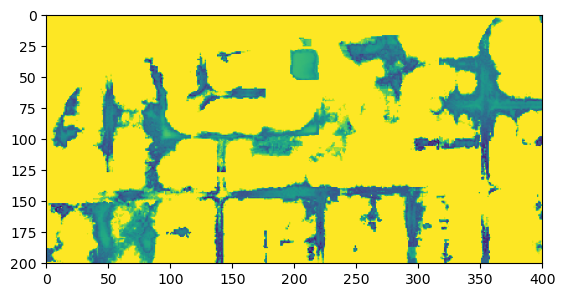

<Axes: >

In [49]:
slope = rasterio.open(r"C:\Users\qijue.chen\Downloads\2D_model_output_sample_data\2D_model_output_sample_data\foo-1-0-0.tif",masked=True)

#transform = Affine.from_gdal(*da.attrs['transform']) # this is important to retain the geographic attributes from the file
show(slope)

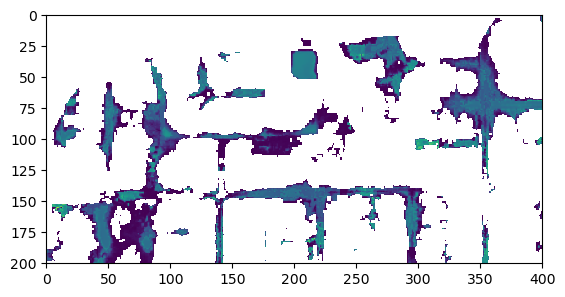

<Axes: >

In [50]:
flood_10yr = rasterio.open(r"C:\Users\qijue.chen\Downloads\2D_model_output_sample_data\2D_model_output_sample_data\foo-3-0-0.tif",masked=True)

#transform = Affine.from_gdal(*da.attrs['transform']) # this is important to retain the geographic attributes from the file
show(flood_10yr)

In [ ]:
da_test = da.nan_to_num(da_test,0)
#da_test = np.nan_to_num(da_test,nan = 0)
da_test